https://github.com/oya163/bert-llm/blob/master/CyberSecurityNER/cyber_security_ner.ipynb

https://huggingface.co/Jean-Baptiste/camembert-ner-with-dates?text=Je+m%27appelle+jean-baptiste+et+j%27habite+%C3%A0+montr%C3%A9al+depuis+fevr+2012+Je+travaille+chez+Microsoft+je+gagne+10000+euros+par+an

# Load modules

In [1]:
!export WANDB_DISABLED=true

In [2]:
from sklearn.preprocessing import LabelEncoder
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, AutoTokenizer
from transformers import AutoModelForTokenClassification, pipeline, DataCollatorForTokenClassification
from tabulate import tabulate
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import evaluate
from datasets import Dataset
import matplotlib.pyplot as plt
import ast

# from seqeval.metrics import classification_report

/home/e077926/miniconda3/Bib/envs/tata_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-13 15:44:14.598715: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 15:44:14.598782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 15:44:14.600712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 15:44:14.606285: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Te

In [3]:
path ='/home/e077926/buscode_2023/05_E2_tata/data/doc_df.csv'
df=pd.read_csv(path)
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,doc,tokens,labels,ner_tags
0,X00016469612,"['TAN', 'WOON', 'YANN', 'BOOK', 'TA', '.K(TAMA...","['O', 'O', 'O', 'I-ORG', 'I-ORG', 'O', 'I-ORG'...","[0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 2, 2, 2, 2, 2, ..."
1,X00016469619,"['TAN', 'WOON', 'YANN', 'INDAH', 'GIFT', '&', ...","['O', 'O', 'O', 'I-ORG', 'I-ORG', 'I-ORG', 'I-...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 0, ..."
2,X00016469620,"['TAN', 'WOON', 'YANN', 'MR', 'D.T.Y.', '(JOHO...","['O', 'O', 'O', 'I-ORG', 'O', 'I-ORG', 'I-ORG'...","[0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, ..."
3,X00016469622,"['TAN', 'WOON', 'YANN', 'YONGFATT', 'ENTERPRIS...","['O', 'O', 'O', 'I-ORG', 'I-ORG', 'O', 'I-LOC'...","[0, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, ..."
4,X00016469623,"['TAN', 'WOON', 'YANN', 'MR', 'D.I.Y.', '(M)',...","['O', 'O', 'O', 'I-ORG', 'I-ORG', 'I-ORG', 'I-...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, ..."


concat dfs

correct chain lists

In [4]:
# Safely convert string representations to list objects
df['tokens'] = df['tokens'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['labels'] = df['labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [5]:
df['ner_tags'] = df['ner_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, int) else x)

In [6]:
def full_label_chain(label_list, label_kind):
    new_labels = label_list.copy()  # Copie de la liste pour éviter de modifier l'originale pendant qu'on itère
    for i in range(1, len(label_list) - 1):  # Itérer sur la liste en ignorant le premier et le dernier élément
        # Vérifier si l'élément actuel est 'O' et entouré par 'I-ORG'
        if label_list[i] == 'O' and label_list[i - 1] == label_kind and label_list[i + 1] == label_kind:
            new_labels[i] = label_kind  # Modifier 'O' en 'I-ORG'
    return new_labels

# Appliquer la fonction à la colonne 'labels'
df['labels'] = df['labels'].apply(lambda x: full_label_chain(x, 'I-ORG'))
df['labels'] = df['labels'].apply(lambda x: full_label_chain(x, 'I-LOC'))

In [7]:
import ast

def convert_to_int_list(string_list):
    try:
        # Safely evaluate the string to a list
        evaluated_list = ast.literal_eval(string_list)
        # Convert each element in the evaluated list to an integer
        return [int(elem) for elem in evaluated_list]
    except ValueError as e:
        # Handle the case where evaluation or conversion fails
        print(f"Error converting {string_list}: {e}")
        return []

# Apply the conversion function to the 'ner_tags' column
df['ner_tags'] = df['ner_tags'].apply(convert_to_int_list)


In [8]:
df

,doc,tokens,labels,ner_tags
0,X00016469612,"[TAN, WOON, YANN, BOOK, TA, .K(TAMAN, DAYA), S...","[O, O, O, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O...","[0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 2, 2, 2, 2, 2, ..."
1,X00016469619,"[TAN, WOON, YANN, INDAH, GIFT, &, HOME, DECO, ...","[O, O, O, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 0, ..."
2,X00016469620,"[TAN, WOON, YANN, MR, D.T.Y., (JOHOR), SDN, BH...","[O, O, O, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O...","[0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, ..."
3,X00016469622,"[TAN, WOON, YANN, YONGFATT, ENTERPRISE, (JM051...","[O, O, O, I-ORG, I-ORG, O, I-LOC, I-LOC, I-LOC...","[0, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, ..."
4,X00016469623,"[TAN, WOON, YANN, MR, D.I.Y., (M), SDN, BHD, (...","[O, O, O, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O...","[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, ..."
...,...,...,...,...
929,X51009447842,"[PASARAYA, BORONG, PINTAR, SDN, BHD, BR, NO.:,...","[I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, O, O, I...","[1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, ..."
930,X51009453729,"[3180303, LIAN, HING, STATIONERY, SDN, BHD, (1...","[O, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, I-LO...","[0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 0, 2, 2, ..."
931,X51009453801,"[3180303, GL, HANDICRAFT, &, TAIL, ORING, 19,,...","[O, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-LOC, ...","[0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, ..."
932,X51009453804,"[3180303, LIAN, HING, STATIONERY, SDN, BHD, (1...","[O, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, I-LO...","[0, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, ..."


In [9]:
type(df['tokens'].iloc[0])

list

In [10]:
type(df['labels'].iloc[0])

list

In [11]:
type(df['ner_tags'].iloc[2])

list

In [12]:
# df.to_csv('/home/azureuser/cloudfiles/code/Users/charlie.marliere/E2/data/doc_3entities_df_wth_gen_data.csv')

# 01 Load my data

# Split

In [13]:
train_df, test_val_df = train_test_split(df, test_size=0.3)
test_df, eval_df = train_test_split(test_val_df, test_size=0.5)

In [14]:
test_df

,doc,tokens,labels,ner_tags
293,X51005746210,"[SEGI, CASH, &, CARRY, SDN., BHD., (317041-W),...","[I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, ...","[1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 0, 0, 0, ..."
506,X51006556610,"[PINGHWAI, TRADING, SDN, BHD, (1211036-W), NO....","[I-ORG, I-ORG, I-ORG, I-ORG, O, I-LOC, I-LOC, ...","[1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
725,X51007339100,"[SANYU, STATIONERY, SHOP, NO., 31G&33G,, JALAN...","[I-ORG, I-ORG, I-ORG, I-LOC, I-LOC, I-LOC, I-L...","[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, ..."
929,X51009447842,"[PASARAYA, BORONG, PINTAR, SDN, BHD, BR, NO.:,...","[I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, O, O, I...","[1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, ..."
816,X51007846360,"[IKANO, HANDEL, SDN, BHD, (1074617K), IKEA, TE...","[I-ORG, I-ORG, I-ORG, I-ORG, O, O, I-LOC, I-LO...","[1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
...,...,...,...,...
504,X51006556596,"[GARDENIA, BAKERIES, (KL), SDN, BHD, (139386, ...","[I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, O, I-LO...","[1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, ..."
867,X51008099083,"[RESTORAN, WAN, SHENG, 002043319-W, NO.2,, JAL...","[I-ORG, I-ORG, I-ORG, O, I-LOC, I-LOC, I-LOC, ...","[1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, ..."
849,X51008042786,"[184, GERBANG, ALAF, RESTAURANTS, SDN, BHD, (6...","[O, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, O, O...","[0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, ..."
884,X51008114283,"[MR., D.I.Y., (KUCHAI), SDN, BHD, (CO, REG, :,...","[I-ORG, I-ORG, I-ORG, I-ORG, I-ORG, O, O, O, O...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, ..."


In [15]:
# En supposant que train_df est un DataFrame pandas avec les colonnes "words" et "ner_tags"
train_dataset = Dataset.from_pandas(train_df)
test_dataset=Dataset.from_pandas(test_df)
eval_dataset = Dataset.from_pandas(eval_df)

In [16]:
train_dataset

Dataset({
    features: ['doc', 'tokens', 'labels', 'ner_tags', '__index_level_0__'],
    num_rows: 653
})

In [17]:
train_dataset[0]['labels']

['I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'O',
 'O',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'I-DATE',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'I-ORG',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'I-MISC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

# Tokenization

In [18]:
# model_checkpoint ="dslim/bert-base-NER"
# model_checkpoint ="bert-base-uncased"
model_checkpoint='Jean-Baptiste/camembert-ner-with-dates'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

originaux

In [19]:
#  Align the number of labels and the tokens
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            # if label % 2 == 1:
            #     label += 1
            new_labels.append(label)

    return new_labels

In [20]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [21]:
type(train_dataset[8]['ner_tags'])

list

In [22]:
train_dataset[8]['labels']

['I-ORG',
 'I-ORG',
 'I-ORG',
 'I-ORG',
 'O',
 'O',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'I-LOC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'I-DATE',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'I-MISC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [23]:
train_dataset[8]['tokens']

['99',
 'SPEED',
 'MART',
 'S/B',
 '(519537-X)',
 'LOP',
 'P.T.',
 '2811,',
 'JALAN',
 'ANGSA,',
 'TAMAN',
 'BERKELEY',
 '41150',
 'KLANG,',
 'SELANGOR',
 '1237-TMN',
 'INDAH',
 'PERDANA',
 'GST',
 'ID.',
 'NO',
 ':',
 '000181747712',
 'INVOICE',
 'NO',
 ':',
 '18418/102/T0262',
 '05:38PM',
 '568268',
 '04-06-18',
 '620',
 'CARNATION',
 'SUSU',
 'KRIMER',
 'S',
 'RM5.00',
 'Z',
 '@2',
 'X',
 'RM',
 '2.50',
 '0715',
 'KNORR',
 'CHICKEN',
 'STOCK',
 '1K',
 'RM15.90',
 'Z',
 'TOTAL',
 'SALES',
 'RM',
 '20.90',
 'CASH',
 'RM',
 '21.00',
 'CHANGE',
 'RM',
 '.10',
 'GST',
 'SUMMARY',
 'AMOUNT(RM)',
 'TAX(RM)',
 'Z',
 '=',
 '0%',
 '20.90',
 '.00',
 'THANK',
 'YOU.',
 'PLEASE',
 'COME',
 'AGAIN',
 'KEEP',
 'THE',
 'INVOICE',
 'FOR',
 'APPLICABLE',
 'RETURNS']

In [24]:
# Tokenizer tous les exemples du dataset
tokenized_datasets_train = train_dataset.map(
    tokenize_and_align_labels,
    batched=True,
)

Map: 100%|██████████| 653/653 [00:00<00:00, 1614.06 examples/s]


In [25]:
# Tokenizer tous les exemples du dataset
tokenized_datasets_eval = eval_dataset.map(
    tokenize_and_align_labels,
    batched=True,
)

Map: 100%|██████████| 141/141 [00:00<00:00, 1899.61 examples/s]


In [26]:
# Tokenizer tous les exemples du dataset
tokenized_datasets_test= test_dataset.map(
    tokenize_and_align_labels,
    batched=True,
)

Map: 100%|██████████| 140/140 [00:00<00:00, 1667.51 examples/s]


# Fine Tuning

## Data Collator

In [27]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

## Setup Evaluation

In [28]:
# new_entity_list=['O','I-LOC','I-MISC','I-ORG', 'I-DATE']

In [29]:
for_model_list= ['O','I-ORG','I-LOC', 'I-DATE','I-MISC', 'I-PER']

In [30]:
metric = evaluate.load("seqeval")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[for_model_list[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [for_model_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [31]:
id2label = {i: label for i, label in enumerate(for_model_list)}
label2id = {v: k for k, v in id2label.items()}

In [32]:
id2label

{0: 'O', 1: 'I-ORG', 2: 'I-LOC', 3: 'I-DATE', 4: 'I-MISC', 5: 'I-PER'}

In [33]:
label2id

{'O': 0, 'I-ORG': 1, 'I-LOC': 2, 'I-DATE': 3, 'I-MISC': 4, 'I-PER': 5}

# freez layers

In [34]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)
# Geler tous les paramètres du modèle
for param in model.parameters():
    param.requires_grad = False

# Identifier les indices des dernières couches BertLayer que vous souhaitez fine-tuner
# Exemple : fine-tuner les deux dernières couches de BertEncoder
layers_to_finetune = [len(model.roberta.encoder.layer) - 1, len(model.roberta.encoder.layer) - 1]

# Dé-geler les paramètres des couches spécifiées
for i in layers_to_finetune:
    for param in model.roberta.encoder.layer[i].parameters():
        param.requires_grad = True

In [35]:
layers_to_finetune

[11, 11]

In [36]:
model.config.num_labels

6

In [37]:
model.config.id2label= {0: 'O', 1: 'I-ORG', 2: 'I-LOC', 3: 'I-DATE', 4: 'I-MISC', 5: 'I-PER'}

In [38]:
model.config.label2id={'O': 0, 'I-ORG': 1, 'I-LOC': 2, 'I-DATE': 3, 'I-MISC': 4, 'I-PER': 5}

In [39]:
model.base_model

CamembertModel(
  (embeddings): CamembertEmbeddings(
    (word_embeddings): Embedding(32005, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): CamembertEncoder(
    (layer): ModuleList(
      (0-11): 12 x CamembertLayer(
        (attention): CamembertAttention(
          (self): CamembertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): CamembertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
     

In [40]:
model.config

CamembertConfig {
  "_name_or_path": "Jean-Baptiste/camembert-ner-with-dates",
  "architectures": [
    "CamembertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "I-ORG",
    "2": "I-LOC",
    "3": "I-DATE",
    "4": "I-MISC",
    "5": "I-PER"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "I-DATE": 3,
    "I-LOC": 2,
    "I-MISC": 4,
    "I-ORG": 1,
    "I-PER": 5,
    "O": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 32005
}

# Look at tokenized dictionnary

In [41]:
tokenized_datasets_train

Dataset({
    features: ['doc', 'tokens', 'labels', 'ner_tags', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 653
})

In [42]:
tokenized_datasets_eval

Dataset({
    features: ['doc', 'tokens', 'labels', 'ner_tags', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 141
})

In [43]:
tokenized_datasets_train[0]

{'doc': 'X51008142030',
 'tokens': ['THREE',
  'SEAFOOD',
  'RESTAURANT',
  'SDN',
  'BHD',
  '(1120908-M)',
  'NO.1,',
  'TAMAN',
  'SRI',
  'JALAN',
  'AIR',
  'HITAM',
  '43800',
  'SELANGOR.',
  'GST',
  'REG.',
  'NO',
  ':',
  '000670224384)',
  'TAX',
  'INVOICE',
  'TABLE',
  '37',
  'BILL#:V001-539829',
  'ORDER#:',
  '139931',
  'DATE',
  ':',
  '05-06-2018',
  '20:23:14',
  'CASHIER:',
  '113',
  'CASHIER',
  'PAX(S):',
  '0',
  'QTY',
  'DESCRIPTION',
  'TOTAL',
  'TAX',
  '1',
  'D',
  '15.00',
  'SR',
  'OMELLETE',
  'ITEM',
  '1',
  'D',
  '10.00',
  'SR',
  'VEGE',
  'ITEM',
  '(S)',
  '1',
  'D',
  '22.00',
  'SR',
  'RICE',
  'W',
  'SEAFOOD',
  '/MEAT',
  'ITEM',
  'SINGLE',
  '1',
  'D',
  '5.00',
  'SR',
  'BEVERAGE',
  'TOTAL',
  '(EXCLUDING',
  'GST):',
  '52.00',
  'TOTAL',
  '(INCLUSIVE',
  'OF',
  'GST):',
  '52.00',
  'TOTAL',
  ':',
  '52.00',
  'CLOSED:',
  '1',
  '20:56:06',
  'SERVER:',
  '113',
  'CASHIER',
  'CASH',
  ':',
  '52.00',
  'GST',
  'SUMMARY

In [44]:
tokenized_datasets_train[2]

{'doc': 'X51008099086',
 'tokens': ['RESTORAN',
  'WAN',
  'SHENG',
  '002043319-W',
  'NO.2,',
  'JALAN',
  'TEMENGGUNG',
  '19/9,',
  'SEKSYEN',
  '9,',
  'BANDAR',
  'MAHKOTA',
  '43200',
  'SELANGOR',
  'GST',
  'REG',
  'NO:',
  '001335787520',
  'TAX',
  'INVOICE',
  'INV',
  'NO.',
  ':',
  '1216991',
  'CASHIER:',
  'NICOLE',
  'DATE',
  ':',
  '29-06-2018',
  '16:13:05',
  'DESCRIPTION',
  'QTY',
  'U.PRICE',
  'TOTAL',
  'TAX',
  'KOPI',
  'O',
  '(B)',
  '1',
  'X',
  '2.00',
  '2.00',
  'ZRL',
  'CHAM',
  '(B)',
  '1',
  'X',
  '2.10',
  '2.10',
  'ZRL',
  'NESCAFE',
  '(B)',
  '1',
  'X',
  '2.50',
  '2.50',
  'ZRL',
  'TAKE',
  'AWAY',
  '3',
  'X',
  '0.20',
  '0.60',
  'ZRL',
  'TOTAL',
  'QTY:',
  '6',
  'TOTAL',
  '(EXCLUDING',
  'GST):',
  '7.20',
  'TOTAL',
  '(INCLUSIVE',
  'OF',
  'GST):',
  '7.20',
  'TOTAL',
  ':',
  '7.20',
  'CASH',
  ':',
  '7.20',
  'GST',
  'SUMMARY',
  'AMOUNT(RM)',
  'TAX(RM)',
  'ZRL',
  '(@',
  '0%)',
  '7.20',
  '0.00'],
 'labels': [-1

# Training

optimizers : https://huggingface.co/docs/transformers/v4.37.2/en/main_classes/trainer#transformers.TrainingArguments

définitions : https://inside-machinelearning.com/recall-precision-f1-score/

In [47]:
args = TrainingArguments(
    "bert-finetuned-ner-16-doc",
    evaluation_strategy="epoch",
    learning_rate=10e-6,
    num_train_epochs=1000,
    weight_decay=0.02,
    push_to_hub=False,
    metric_for_best_model = 'f1',
    load_best_model_at_end=True,
    save_strategy="epoch",
    optim='adamw_hf',
    logging_steps=10,
    report_to="none",

    eval_steps=500,
    save_steps=1500,
    # per_device_train_batch_size=8,  # Taille du batch pour l'entraînement
    # per_device_eval_batch_size=8,
    
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_eval,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)],

)
trainer.train()

/home/e077926/miniconda3/Bib/envs/tata_env/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a CamembertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.479700,0.517699,0.003927,0.008785,0.005427,0.833658


/home/e077926/miniconda3/Bib/envs/tata_env/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyboardInterrupt: 

# Graphic representation

## Confusion matrix

In [ ]:
# Obtenir les prédictions
predictions, labels, _ = trainer.predict(tokenized_datasets_test)
predictions = np.argmax(predictions, axis=2)

/anaconda/envs/e2_env/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Confusion Matrix après entrainnement 10')

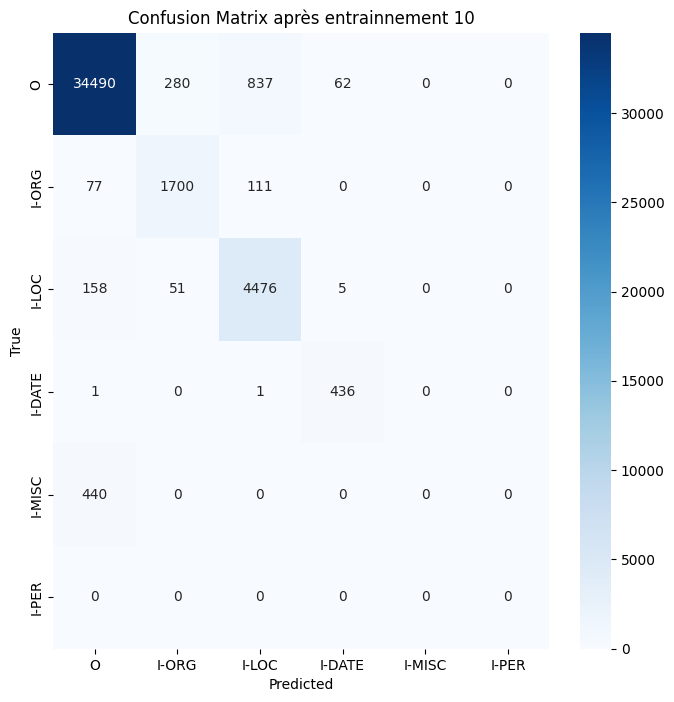

In [ ]:
# Aplatir les listes
true_labels = []
pred_labels = []
for i, label in enumerate(labels):
    for j, label_id in enumerate(label):
        if label_id != -100:  # Ignorer les tokens spéciaux
            true_labels.append(label_id)
            pred_labels.append(predictions[i][j])

# Convertir les indices en étiquettes textuelles (selon votre mapping d'indices)
# Vous devez définir `id2label` basé sur votre modèle ou votre Tokenizer
true_label_text = [id2label[id] for id in true_labels]
pred_label_text = [id2label[id] for id in pred_labels]

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(true_label_text, pred_label_text, labels=list(id2label.values()))

# Sauvegarder le graphique Seaborn dans un fichier image (par exemple, PNG)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=for_model_list, yticklabels=for_model_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix après entrainnement 10')

## Loss and Accuracy

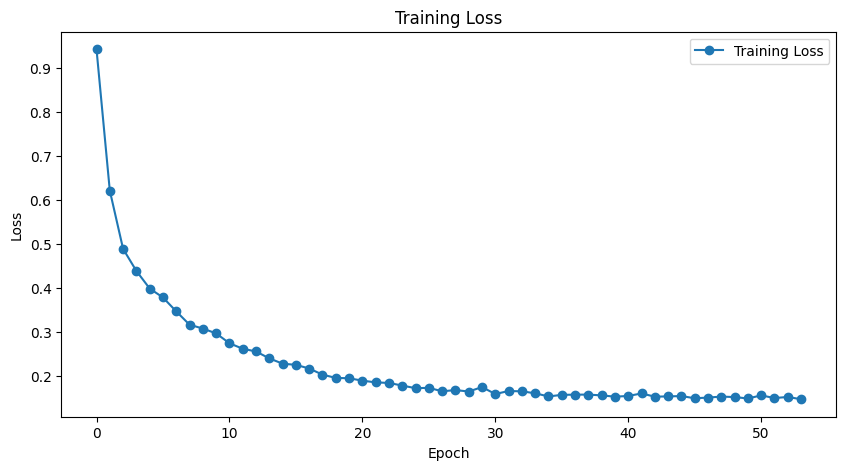

In [ ]:
# Récupération des métriques d'entraînement
train_metrics = trainer.state.log_history

# Extraction des métriques spécifiques que vous souhaitez tracer (par exemple, la perte)
train_loss = [metric['loss'] for metric in train_metrics if 'loss' in metric]
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', marker='o')

plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

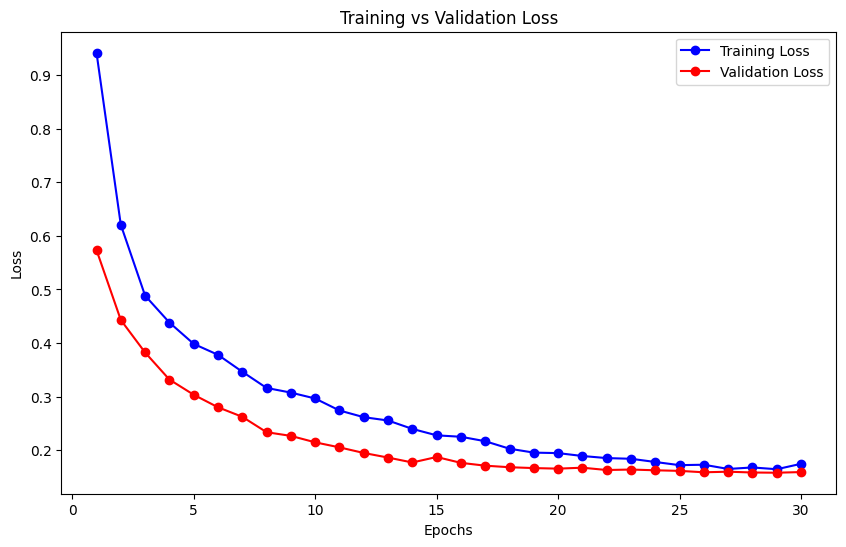

In [ ]:
import matplotlib.pyplot as plt

# Après l'entraînement, vous pouvez accéder à l'historique des logs comme ceci:
log_history = trainer.state.log_history

# Initialiser les listes pour stocker les pertes d'entraînement et de validation
training_loss = []
validation_loss = []

# Extraire les pertes d'entraînement et de validation de log_history
for log in log_history:
    if 'loss' in log:  # C'est une entrée de perte d'entraînement
        training_loss.append(log['loss'])
    elif 'eval_loss' in log:  # C'est une entrée de perte de validation
        validation_loss.append(log['eval_loss'])

# Assurez-vous que nous avons les mêmes nombres de points pour les deux courbes
min_length = min(len(training_loss), len(validation_loss))
training_loss = training_loss[:min_length]
validation_loss = validation_loss[:min_length]
epochs = range(1, min_length + 1)

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b-o', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-o', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model

In [ ]:
saved_model_path='custom_model-15-doc'
trainer.save_model(saved_model_path)

# Evaluate

In [ ]:
predictions = trainer.predict(tokenized_datasets_eval)

/anaconda/envs/e2_env/lib/python3.10/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metrics = ['precision', 'recall', 'f1', 'accuracy']
prediction_results = []

for key, val in predictions.metrics.items():
    if any(item in key for item in metrics):
        prediction_results.append([key, str(round(val,4)*100)+'%'])

print(tabulate(prediction_results, headers=['Metric', 'Score']))

Metric          Score
--------------  ------------------
test_precision  35.07%
test_recall     38.95%
test_f1         36.91%
test_accuracy   95.28999999999999%


# Inference

In [ ]:
inference= """MR. D.I.¥. (KUCHAT) SDN BHD
CO-REG:750441-W
LOT 1851-A & 1851-B, JALAN KPB 6,
KAWASAN PERINDUSTRIAN BALAKONG,
43300 SERI KEMBANGAN, SELANGOR
(GST ID No :000473792512)
(TESCO EXTRA KAJANG)
-TAX INVOICE-

BOOSTER CABLE XH-500A +*§
CE72 - 10
9001620 1X 29.90 298,90
MOTH BALLS 1506 *§
EC21-41-71 - 10/100
9063977 1X 2,10 2,10
DIY GOLD TWIST DRILL 3MM *§
LB22 - 20/1500
9071246 1X 2,50 2,50
HSS TWIST DRILL 6*160MM *§
LG32-42 - 10/400
6909906163107 1X 3.30 3,30

Item(s) : 4 Qty(s) : 4
TOTAL INCL. GSTe6K RM 37.80
CASH RM 40.00
CHANGE RM 2.20

GST Summary Amt(RM) = Tax(RM)
GST S@6% 35.66 2.14

08-03-17 13:42 SHO1 BO28 = 12 000017473
OPERATOR TRAINEE

EXCHANGE ARE ALLOWED WITHIN
7 DAY WITH RECEIPT.
STRICTLY NO CASH REFUND.



ee are can"""

In [ ]:
token_classifier = pipeline(
    "token-classification", model=saved_model_path, aggregation_strategy="simple"
)
results = token_classifier(inference)

In [ ]:
prediction_results = []
for each_entity in results:
    prediction_results.append([each_entity['word'], each_entity['entity_group']])

print(tabulate(prediction_results, headers=['Word', 'Predictions']))

Word                                                                                                Predictions
--------------------------------------------------------------------------------------------------  -------------
MR. D.I.¥. (KUCHAT) SDN BHD                                                                         ORG
CO                                                                                                  LOC
W LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR  LOC
TRA KAJANG                                                                                          LOC
08-03-17                                                                                            DATE
